Starting script to add geometry to counties table...
Filtering to Colorado and Texas counties...
Checking existing counties in database...
Found 318 matching counties in database out of 318 CO/TX counties
Updating existing counties with geometry...
Updated 10 counties...
Updated 20 counties...
Updated 30 counties...
Updated 40 counties...
Updated 50 counties...
Updated 60 counties...
Updated 70 counties...
Updated 80 counties...
Updated 90 counties...
Updated 100 counties...
Updated 110 counties...
Updated 120 counties...
Updated 130 counties...
Updated 140 counties...
Updated 150 counties...
Updated 160 counties...
Updated 170 counties...
Updated 180 counties...
Updated 190 counties...
Updated 200 counties...
Updated 210 counties...
Updated 220 counties...
Updated 230 counties...
Updated 240 counties...
Updated 250 counties...
Updated 260 counties...
Updated 270 counties...
Updated 280 counties...
Updated 290 counties...
Updated 300 counties...
Updated 310 counties...

Verifying geome

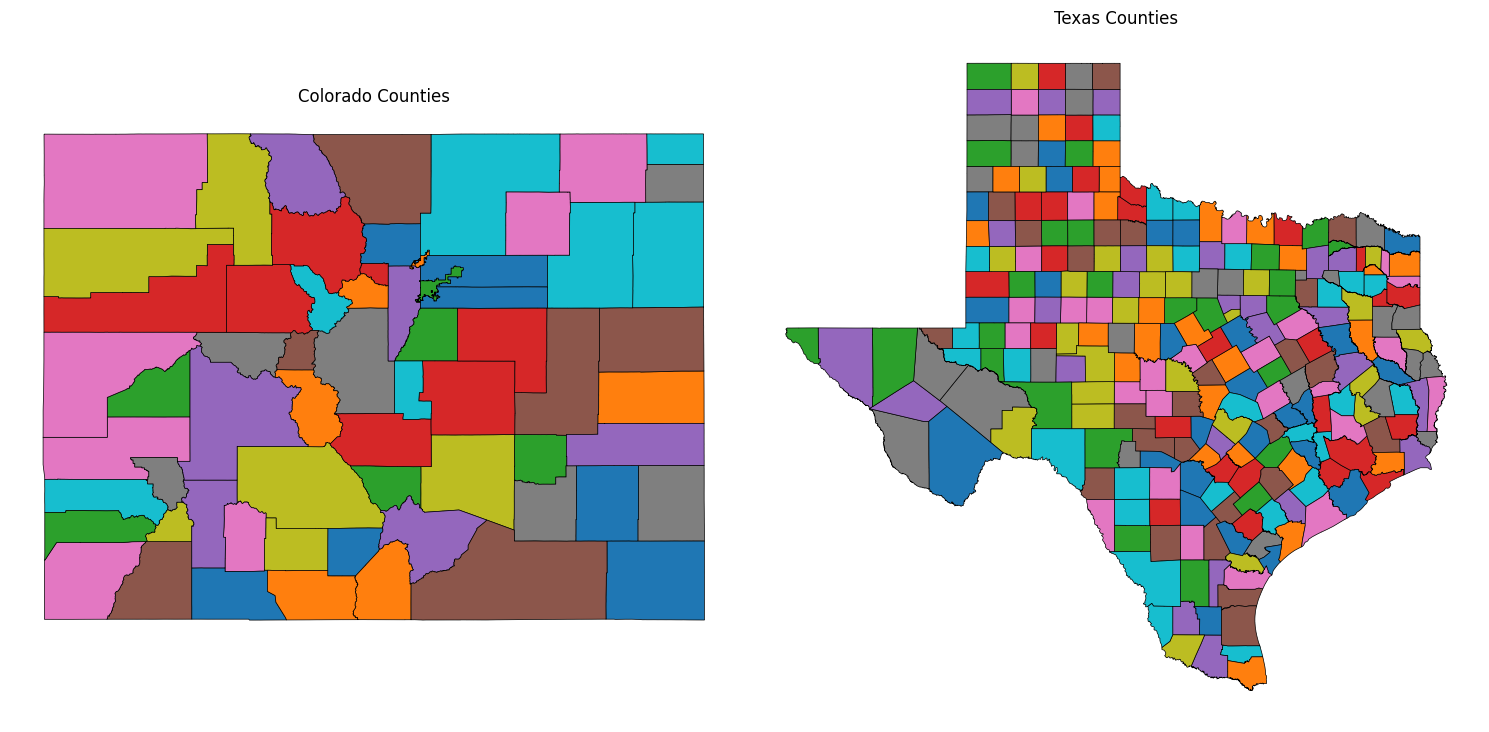

In [5]:
import os
import geopandas as gpd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

def add_geometry_to_counties_table():
    """
    Script to add geometry data to the counties table in a PostGIS database.
    Fetches county boundaries from US Census TIGER/Line files and updates
    the existing counties table with geometry data.
    """
    print("Starting script to add geometry to counties table...")
    
    # Load environment variables
    load_dotenv()
    
    # Create database connection
    DB_NAME = os.environ["DB_NAME"]
    DB_USER = os.environ["DB_USER"]
    DB_PASSWORD = os.environ["DB_PASSWORD"]
    DB_HOST = os.environ.get("DB_HOST", "localhost")
    DB_PORT = os.environ.get("DB_PORT", "5432")
    
    connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_string)
    
    # Download US county boundaries from Census TIGER/Line (2023 version)
    print("Downloading county boundaries from Census TIGER/Line...")
    counties_gdf = gpd.read_file("/home/dadams/Downloads/tl_2023_us_county.zip")
    
    # Create STATEFP + COUNTYFP as county_fips
    counties_gdf['county_fips'] = counties_gdf['STATEFP'] + counties_gdf['COUNTYFP']
    
    # Filter to just Colorado and Texas counties (FIPS codes 08 and 48)
    print("Filtering to Colorado and Texas counties...")
    co_tx_counties = counties_gdf[counties_gdf['STATEFP'].isin(['08', '48'])].copy()
    
    # Ensure proper projection for PostGIS (EPSG:4326 is WGS84)
    if co_tx_counties.crs != 'EPSG:4326':
        co_tx_counties = co_tx_counties.to_crs('EPSG:4326')
    
    # Check which counties already exist in the database
    print("Checking existing counties in database...")
    with engine.connect() as conn:
        existing_counties = pd.read_sql("SELECT county_fips FROM counties", conn)
    
    existing_fips = set(existing_counties['county_fips'])
    
    # Match with counties in the database
    co_tx_counties['exists_in_db'] = co_tx_counties['county_fips'].isin(existing_fips)
    
    # Report on matching status
    print(f"Found {co_tx_counties['exists_in_db'].sum()} matching counties in database out of {len(co_tx_counties)} CO/TX counties")
    
    # --------------------
    # Update existing counties with geometry
    # --------------------
    
    print("Updating existing counties with geometry...")
    
    # Track success and failures
    successful_updates = 0
    failed_updates = 0
    
    # For each county that exists in the database, update its geometry
    for idx, row in co_tx_counties[co_tx_counties['exists_in_db']].iterrows():
        try:
            # Convert the geometry to WKT format for PostGIS
            geom_wkt = row.geometry.wkt
            
            # Update the county's geometry in the database
            with engine.begin() as conn:
                query = text("""
                    UPDATE counties 
                    SET geom = ST_GeomFromText(:geom, 4326) 
                    WHERE county_fips = :fips
                """)
                conn.execute(query, {"geom": geom_wkt, "fips": row['county_fips']})
            
            successful_updates += 1
            
            # Print progress every 10 counties
            if successful_updates % 10 == 0:
                print(f"Updated {successful_updates} counties...")
                
        except Exception as e:
            print(f"Failed to update county {row['county_fips']} ({row['NAME']}): {e}")
            failed_updates += 1
    
    # --------------------
    # Insert any missing counties
    # --------------------
    
    missing_counties = co_tx_counties[~co_tx_counties['exists_in_db']]
    
    if len(missing_counties) > 0:
        print(f"\nInserting {len(missing_counties)} counties not found in database...")
        
        for idx, row in missing_counties.iterrows():
            try:
                # Convert the geometry to WKT format for PostGIS
                geom_wkt = row.geometry.wkt
                
                # Insert the county into the database
                with engine.begin() as conn:
                    query = text("""
                        INSERT INTO counties (county_fips, name, state, geom)
                        VALUES (:fips, :name, :state, ST_GeomFromText(:geom, 4326))
                    """)
                    conn.execute(query, {
                        "fips": row['county_fips'], 
                        "name": row['NAME'],
                        "state": row['STATEFP'],
                        "geom": geom_wkt
                    })
                
                print(f"Inserted county {row['county_fips']} ({row['NAME']})")
                
            except Exception as e:
                print(f"Failed to insert county {row['county_fips']} ({row['NAME']}): {e}")
                failed_updates += 1
    
    # --------------------
    # Verify the update was successful
    # --------------------
    
    print("\nVerifying geometry update...")
    with engine.connect() as conn:
        result = conn.execute(text("""
            SELECT COUNT(*) FROM counties WHERE geom IS NOT NULL AND (state = '08' OR state = '48')
        """)).fetchone()
        
        counties_with_geom = result[0]
        
        result = conn.execute(text("""
            SELECT COUNT(*) FROM counties WHERE state = '08' OR state = '48'
        """)).fetchone()
        
        total_counties = result[0]
    
    print(f"Counties with geometry: {counties_with_geom} out of {total_counties} total CO/TX counties")
    
    # Fix any issues with the geometry column (make sure it's properly indexed)
    print("\nEnsuring geometry SRID is correctly set and spatial index exists...")
    with engine.begin() as conn:
        # Update SRID directly if any rows have an undefined SRID (e.g., 0)
        conn.execute(text("""
            UPDATE counties SET geom = ST_SetSRID(geom, 4326) 
            WHERE ST_SRID(geom) = 0;
        """))
        
        # Create spatial index if it doesn't exist
        conn.execute(text("""
            CREATE INDEX IF NOT EXISTS idx_counties_geom ON counties USING GIST (geom);
        """))

    
    print("\nGeometry update complete!")
    print(f"Successfully updated: {successful_updates} counties")
    print(f"Failed updates: {failed_updates} counties")
    
    return co_tx_counties

# Run the function if script is executed directly
if __name__ == "__main__":
    import pandas as pd
    counties_with_geometry = add_geometry_to_counties_table()
    
    # After updating, you can create visualizations to confirm success
    print("\nCreating test visualization to confirm geometry was added correctly...")
    
    import matplotlib.pyplot as plt
    
    # Create a simple map to verify the geometry was added correctly
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    
    # Plot Colorado counties
    counties_with_geometry[counties_with_geometry['STATEFP'] == '08'].plot(
        ax=ax[0], 
        edgecolor='black',
        linewidth=0.5,
        column='NAME',
        legend=False
    )
    ax[0].set_title('Colorado Counties')
    ax[0].set_axis_off()
    
    # Plot Texas counties
    counties_with_geometry[counties_with_geometry['STATEFP'] == '48'].plot(
        ax=ax[1], 
        edgecolor='black',
        linewidth=0.5,
        column='NAME',
        legend=False
    )
    ax[1].set_title('Texas Counties')
    ax[1].set_axis_off()
    
    plt.tight_layout()
    plt.savefig('county_geometry_verification.png', dpi=300)
    
    print("Verification map saved as 'county_geometry_verification.png'")